In [2]:
from functools import partial

import mlflow
from config import Params
from joblib import Parallel, delayed

from experiment import evaluation_loop
from NEExT.outliers.benchmark_utils.data_loading import load_abcdo_data, load_pygod_data

In [3]:
def prepare_dataset(data: str):
    edges_df, mapping_df, features_df, _ = load_pygod_data(data, hide_frac={0: 0, 1: 0})
    community_id = features_df.is_outlier
    return edges_df, mapping_df, features_df, community_id


data = "books"
mlflow.set_tracking_uri(uri="http://127.0.0.1:5001")
experiment_name = f"/{data}"
mlflow.set_experiment(experiment_name)

data_fun = partial(prepare_dataset, data=data)

In [12]:
feature = 'all'
vec_len = 1
k_hop = 0
param = Params(
    comment=f"global_structural_features_{feature}_{k_hop}_{vec_len}",
    global_structural_feature_list=[feature],
    global_feature_vector_length=vec_len,
    embeddings_strategy="feature_embeddings",
    egonet_k_hop=k_hop,
)

In [13]:
import traceback
from functools import partial
from typing import Callable

import mlflow
from config import Params
from embedding_utils import (
    add_positional_features,
    compute_embedding,
    compute_global_features,
    compute_local_node_features,
    compute_local_structural_features,
    node2vec_embedding,
)
from joblib import Parallel, delayed
from modeling_utils import make_charts, run_experiments, train_random_model

from NEExT.collections import EgonetCollection
from NEExT.datasets import GraphDataset
from NEExT.io import GraphIO

with mlflow.start_run(run_name=param.comment):
    try:
        partial_metrics = {}
        edges_df, mapping_df, features_df, community_id = data_fun()
        graph_io = GraphIO()
        graph_collection = graph_io.load_from_dfs(
            edges_df=edges_df,
            node_graph_df=mapping_df,
            node_features_df=features_df,
            graph_type="igraph",
            filter_largest_component=param.filter_largest_component,
        )

        global_structural_node_features = compute_global_features(param, partial_metrics, graph_collection)
        
        egonet_collection = EgonetCollection(egonet_feature_target=param.egonet_target, skip_features=param.egonet_skip_features)
        egonet_collection.compute_k_hop_egonets(graph_collection, param.egonet_k_hop)

        structural_features = compute_local_structural_features(param, partial_metrics, egonet_collection)
        features = compute_local_node_features(param, egonet_collection, global_structural_node_features)

        structural_features, features = add_positional_features(param, egonet_collection, structural_features, features)

        embeddings = compute_embedding(param, egonet_collection, structural_features, features)

        # dataset = GraphDataset(egonet_collection, embeddings)
        # run_experiments(param, partial_metrics, dataset)
        # make_charts(param, features_df, community_id, dataset)
    except Exception as e:
        print(e)

/home/quak/development/NEExT/.venv/lib/python3.11/site-packages/pygod/utils/utility.py:173: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


🏃 View run global_structural_features_all_0_1 at: http://127.0.0.1:5001/#/experiments/873880819927185239/runs/178cb600a28d4ae2bbd42c42ecd12515
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/873880819927185239


In [16]:
# features.features_df

<Axes: xlabel='betastar_0_global', ylabel='Probability'>

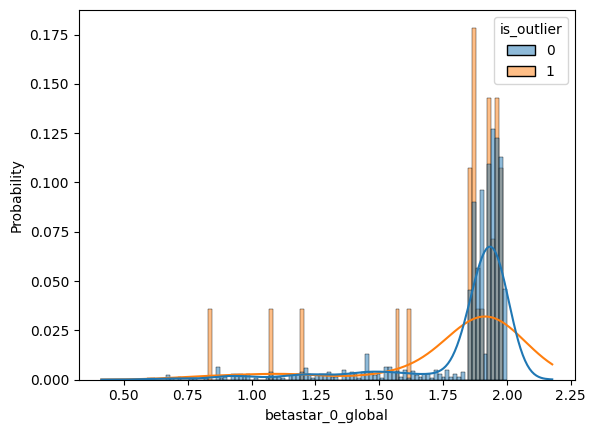

In [6]:
import seaborn as sns

x = global_structural_node_features.features_df.merge(features_df)
kwargs = dict(kde=True, stat='probability', kde_kws={'cut': 3})
sns.histplot(x, x='betastar_0_global',hue='is_outlier', **kwargs, common_norm=False)

<Axes: xlabel='emb_0_feat', ylabel='Probability'>

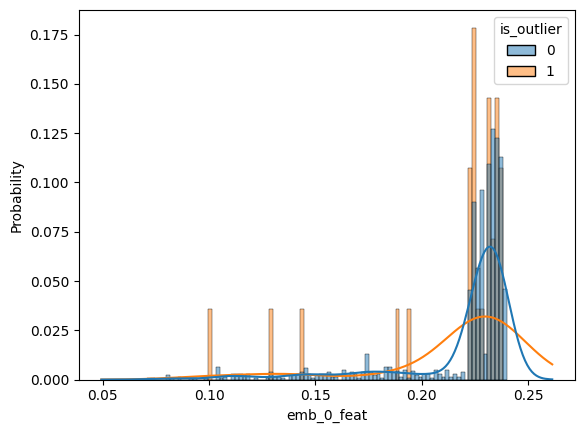

In [7]:
x = embeddings.embeddings_df.rename(columns={'graph_id': 'node_id'}).merge(features_df)
kwargs = dict(kde=True, stat='probability', kde_kws={'cut': 3})
sns.histplot(x, x='emb_0_feat',hue='is_outlier', **kwargs, common_norm=False)

In [17]:
dataset = GraphDataset(egonet_collection, embeddings)

In [18]:
from sklearn.ensemble import IsolationForest
import colorcet as cc
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import mlflow
import numpy as np
import seaborn as sns
import umap
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split


model_name, model = ("lr", LogisticRegression(max_iter=1000, random_state=13))
x_train, x_test, y_train, y_test = train_test_split(
    dataset.X_labeled,
    dataset.y_labeled,
    test_size=0.2,
    random_state=13,
    stratify=dataset.y_labeled,
)

model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_pred_prob = model.predict_proba(x_test)[:, 1]

metrics = dict(
    accuracy_metric=accuracy_score(y_test, y_pred),
    auc_metric=roc_auc_score(y_test, y_pred_prob, average="micro", multi_class="ovr"),
    ap_metric=average_precision_score(y_test, y_pred_prob, average="micro"),
    f1_metric=f1_score(y_test, y_pred, average="micro"),
)

In [19]:
from sklearn.model_selection import TunedThresholdClassifierCV
from sklearn.metrics import make_scorer
scorer = make_scorer(roc_auc_score)
# scorer = make_scorer(f1_score, average='micro')

th_model = TunedThresholdClassifierCV(model, scoring=scorer)
X, y = x_train, y_train
# model.fit(X, y)
scorer(th_model.fit(X, y), X, y)

0.5921353826030085

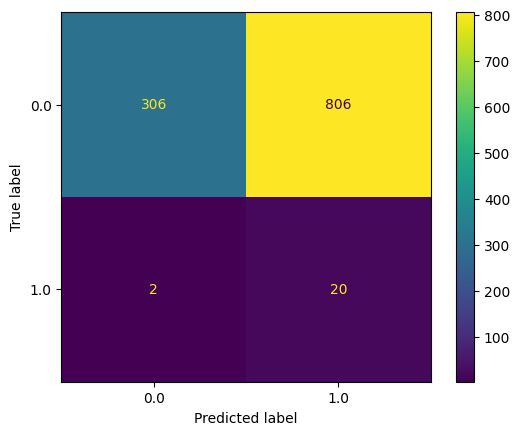

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(th_model, X, y)

In [12]:
metrics

{'accuracy_metric': 0.99,
 'auc_metric': 0.9980050505050505,
 'ap_metric': 0.9591743119266056,
 'f1_metric': 0.99}